# Setting up notebook & downloading data and libraries

In [1]:
#  Change directory to folder with 'cc.ru.300.vec' pretrained embeddings for rus_corpora
#  fastText(ru) 
#  embeddings was taken from 
#  https://github.com/yandexdataschool/nlp_course/blob/2020/week01_embeddings/homework.ipynb
#  download at https://yadi.sk/d/3yG0-M4M8fypeQ
#  train.csv from competition page
#  test.csv from competition page

In [2]:
# Downloading necessary libraries
# Common
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# NLP
import gensim
from gensim.models import KeyedVectors
import nltk

# ML
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn
import torch.nn.functional as F
from tqdm import tnrange
from sklearn.metrics import f1_score

In [3]:
data = pd.read_csv('train.csv', sep='\t')
# data.drop('Unnamed: 0', axis='columns', inplace=True)
data.head(2)

,text,class
0,В Синьцзян-Уйгурском автономном районе Китая С...,true
1,Режиссер Дэвид Линч один из создателей телесер...,true


In [4]:
# Data stats
print(len(data))
i = 0
print(data['text'][i])

23883
В Синьцзян-Уйгурском автономном районе Китая СУАР уйгурам будут давать по 10 тысяч юаней более 162 тысячи долларов за брак с представителями титульной нации  ханьцами. Местные власти сообщили об этом на своем официальном сайте передает South China Morning Post.Из-за процветающих в районе сепаратистских настроений Синьцзян давно является головной болью для Пекина. Снять напряженность и укрепить связи между местным населением и ханьцами власти Китая планируют с помощью программы поддержки межэтнических браков.Как отмечает издание для СУАР 10 тысяч юаней  это большие деньги учитывая что средний годовой доход на душу населения составляет всего 75 тысяч юаней более 12 тысячи долларов.Материалы по теме1117 13 июня 2014Великая антитеррористическая  стенаНа борьбу с внутренними врагами КНР тратит больше средств чем на оборону страныПомимо этого смешанные пары за каждый год прожитый в гармонии друг с другом будут получать по 50 тысяч юаней более 8 тысяч долларов. Дети рожденные в браке ме

In [5]:
# Data stats
data.count()

text     23878
class    23883
dtype: int64

# NLP part

In [6]:
# creating tokenizer and downloading embeddings FastText(ru)
tokenizer = nltk.tokenize.WordPunctTokenizer()
ru_emb = KeyedVectors.load_word2vec_format("cc.ru.300.vec")

In [7]:
# dropping nan values & preparing text and target labels
data.dropna(inplace=True)
data['class'] = data['class'].apply(lambda x: 1 if x=='true' else 0)
data['text'] = data['text'].apply(lambda l: ' '.join(tokenizer.tokenize(str(l))))

Done


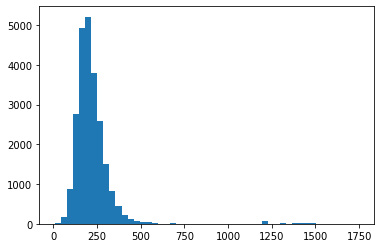

In [8]:
### checking text length statistic
b = []
for text in data['text']:
    if isinstance(text, str): 
        b.append(len(text.split()))
plt.hist(b, bins=50)
print('Done')

In [9]:
# creating dict from tokens to their identifiers
token_to_id = {word:i for i, word in enumerate(ru_emb.index2word)}

In [10]:
# UNK for unseen words 
# PAD for empty words
UNK, PAD = 'unknown', 'pad'
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))   
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix 
    return matrix

# ML part

In [11]:
# spliting data into train and validation sets
# train data
data_train, data_val = train_test_split(data, test_size=0.05, random_state=42)
print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  22684
Validation size =  1194


In [12]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    batch = {}
    batch['text'] = as_matrix(data['text'].values, max_len)
    batch['class'] = data['class'].values
    return batch

In [13]:
batch = generate_batch(data_train, 3, max_len=10)
print(batch)

{'text': array([[   205,    191,     32,    166,     65,   1314,     69,   4607,
          4081,     23],
       [ 59339,     35,     14,   4705, 130630,  10521,   9223,   4227,
         13930,    313],
       [  1386,  25481,  25481,  11808,   3137,   3254,  25481,   6252,
            19, 379274]], dtype=int32), 'class': array([1, 1, 1])}


In [14]:
# Different pooling layers

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
    def forward(self, x):
        return x.max(dim=self.dim)[0]
    
class GlobalAveragePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.mean(dim=self.dim)

class SoftmaxAveragePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
    def forward(self,x):
        prob = F.softmax(x,dim=self.dim)
        return (x*prob).sum(dim=self.dim)
    
class AttentivePooling(nn.Module):
    
    def __init__(self, hid_size):
        super(self.__class__, self).__init__()
        self.dense = nn.Linear(hid_size, 1)
        
    def forward(self,x):
        weights = self.dense(x)
        normalized_weights = F.softmax(weights, dim=1)
        return torch.sum(x*normalized_weights, dim=1)

In [15]:
# In order to use pretrained embeddings
# we create this class
class EmbeddingLayer(nn.Module):
    def __init__(self, device):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(600_000, 300, padding_idx=PAD_IX)
        self.emb.weight.data = torch.tensor(ru_emb.vectors).to(device)
    def forward(self, x):
        return self.emb(x)

## Network architecture
texts -> Embedder -> bLSTM -> [AttentivePooling]*3 -> dense_layers

<img src="network.png">

In [ ]:
class Network(nn.Module):
    def __init__(self):
        """ 
        A simple sequential encoder using bidirectional lstm
        Pooling on top of them (AttentivePooling: 3)
        Everywhere dropout for regularization
        """
        super(self.__class__, self).__init__()
        self.hid = 64
        self.dr1 = nn.Dropout(0.5)
        self.rnn = nn.LSTM(300, self.hid, batch_first=True,bidirectional=True)
        self.pool1 = AttentivePooling(2*self.hid)
        self.pool2 = AttentivePooling(2*self.hid)
        self.pool3 = AttentivePooling(2*self.hid)
        self.dr2 = nn.Dropout(0.5)
        self.dense1 = nn.Linear(6*self.hid, self.hid)
        self.dr3 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(self.hid, 2)
        
    def forward(self, x):
        x = self.dr1(x)
        x, prev = self.rnn(x)
        x = torch.cat([self.pool1(x), self.pool2(x), self.pool3(x)], 1)
        x = self.dr2(x)
        x = F.relu(self.dense1(x))
        x = self.dr3(x)
        return self.dense2(x)

In [ ]:
# Sanity check
Embedder = EmbeddingLayer('cpu')
title_encoder = Network()

dummy_x = torch.LongTensor(generate_batch(data_train, 3)['text'])
print(dummy_x.shape)
dummy_v = title_encoder(Embedder(dummy_x))

assert tuple(dummy_v.shape) == (dummy_x.shape[0], 2)

del title_encoder
print("Seems fine")

torch.Size([3, 195])
Seems fine


In [ ]:
# if cuda available use "cuda" else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Embedder = EmbeddingLayer(device)
model = Network().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
compute_loss = nn.CrossEntropyLoss()

In [ ]:
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    """
    Iterator over minibatches
    returns: batch of data
    """
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
# training parameters
num_epochs = 100
max_len = 450
batch_size = 64
batches_per_epoch = 100

In [ ]:
def compute_score(prediction, reference):
    
  """
     Computing f1 score on minibatch 
     returns: f1_score numpy array
  """
    res_pred = F.softmax(prediction, dim=-1).argmax(1).cpu().numpy()
    res_true = reference.cpu().numpy()
    return f1_score(res_true, res_pred, average='macro')

## Training loop
__1 step__ - train only encoding network with __fixed__ input embeddings lr = 1e-3 Adam

__2 step__ - __finetune__ end-to-end encoding network + pretrained embeddings lr = 1e-4 Adam

In [ ]:
for epoch_i in range(num_epochs):
    
    #print("Training:")
    train_loss = train_f1 = train_batches = 0    
    model.train(True)
    if epoch_i > 50:
        opt = torch.optim.Adam(itertools.chain(*[Embedder.parameters(), model.parameters()]), lr=1e-4)
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch,verbose = False):

        title_ix = torch.LongTensor(batch["text"]).to(device)
        reference = torch.LongTensor(batch["class"]).to(device)
        prediction = model(Embedder(title_ix))
        loss = compute_loss(prediction, reference)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss += loss.detach().cpu().numpy()
        train_f1 += compute_score(prediction, reference)
        train_batches += 1
    
    print('iter {} train_loss = {} train_f1 = {}'.format(epoch_i,train_loss/train_batches, train_f1/train_batches))
    
    #print("Validation:")
    val_loss = val_f1 = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False,verbose= False):
        title_ix = torch.LongTensor(batch["text"]).to(device)
        reference = torch.LongTensor(batch["class"]).to(device)

        prediction = model(Embedder(title_ix))
        loss = compute_loss(prediction, reference)
        val_loss += loss.detach().cpu().numpy()
        val_f1 += compute_score(prediction, reference)
        val_batches += 1
    
    print('iter {} val_loss = {} val_f1 = {}'.format(epoch_i,val_loss/val_batches, val_f1/val_batches))

iter 0 train_loss = 0.47846045315265656 train_f1 = 0.45550703126900527
iter 0 val_loss = 0.40979525760600444 val_f1 = 0.4556134073634812
iter 1 train_loss = 0.3586019589006901 train_f1 = 0.5271190908181428
iter 1 val_loss = 0.28205705708579015 val_f1 = 0.8105117701444022
iter 2 train_loss = 0.226918307505548 train_f1 = 0.8058351621950401
iter 2 val_loss = 0.14674165207696588 val_f1 = 0.8607229866087271
iter 3 train_loss = 0.1510003624856472 train_f1 = 0.8767898795911566
iter 3 val_loss = 0.16747220963435738 val_f1 = 0.8890300945175853
iter 4 train_loss = 0.12212865186855197 train_f1 = 0.9188872124705573
iter 4 val_loss = 0.08477752851812463 val_f1 = 0.9269974570782552
iter 5 train_loss = 0.1003018338046968 train_f1 = 0.9226844240731518
iter 5 val_loss = 0.07676847566433839 val_f1 = 0.9436159454326625
iter 6 train_loss = 0.09226979120634496 train_f1 = 0.9308366587542565
iter 6 val_loss = 0.06364791551114697 val_f1 = 0.9575109493283815
iter 7 train_loss = 0.09539536006283016 train_f1 = 0

# Create submission file

In [ ]:
data_test = pd.read_csv('test.csv', sep='\t')

In [ ]:
data_test['text'] = data_test['text'].apply(lambda l: ' '.join(tokenizer.tokenize(str(l))))

In [ ]:
data_as_matrix = as_matrix(data_test['text'], max_len=max_len)

In [ ]:
from tqdm import trange

In [ ]:
# You can change to 'cuda' 
# I trained on my own gpu with low memory so i use 'cpu' here
model.train(False)
predictions = torch.zeros(len(data_test),2)
test = torch.LongTensor(data_as_matrix)
model = model.to('cpu')
Embedder = Embedder.to('cpu')
for i in trange(len(data_test)):
    predictions[i,:] = F.softmax(model(Embedder(test[i].unsqueeze(0)))[0],-1).detach()

100%|██████████| 6024/6024 [06:53<00:00, 14.57it/s]


In [ ]:
solutions = predictions.argmax(1).numpy()

In [ ]:
columns = data_test.columns

In [ ]:
for i in range(len(data_test)):
    data_test[columns[1]][i] = 'true' if solutions[i]==1 else 'fake' 

In [ ]:
data_test.to_csv('test_solution.csv', sep='\t')

In [ ]:
# Attention!!!!!
# Rename 'test_solution.csv' to 'test.csv' and zip it to 'test.zip'.
# Then send it to checking system

## Final Score = 0.98951

# Remarks on chosen methods

__Since size of dataset is small enough I tried to use pretrained embeddings/Tfidf feature extractor
and combine it with classical methods such as RandomForest or GradientBoosting.
Results wasn't promising, so I switch to neural networks and main efforts 
was at fighting overfitting and unbalance in targets.__

__tokenizer__ (small effect)

--I tried several tokenizers: with lemmatization, deleting stopwords and punctuation   

__other embeddings__ (small effect)

-- I tried other russian embeddings from github 

-- Here I finetune it, so it effected on quality rather small

__Max_len__ (small effect)

-- Changing max_len also give small effect

__Unbalanced targets__ (small effect)

-- Tried reweight classes in losses

-- Tried to sample balanced (sample fakes more often)

__Network architecture__

-- First attempt based on Conv1d network with AveragePooling instead LSTM with AttentionPooling

-- Main recipe: use bLSTM(or GRU) with several attention pooling

-- To avoid overfitting I used dropout. I tried weight_decay but dropout gain better results

Dataset was small enough to train embeddings from scratch

__Training parameters__

-- To accelerate training I used minibatch and Adam optimizer.Training was on GPU 1050Ti (4Gb Ram)

-- I tried to change batch_size and epoch from which finetune was started (small effect)

# TO DO

__1) Use transformer pretrained models (BERT from deeppavlov for rus)__

__2) Try to Ensembling/Stacking models__

__3) Augment somehow data (reordering??)__

__4) Use label smoothing__